# Probabilistic Forecasting: Conformal Calibration

Conformal prediction is a framework for constructing prediction intervals that are valid with respect to the coverage probability. In addition to generating prediction intervals from point forecasts, conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalInterval` transformer.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
There are several well-established <a href="https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html" target="_blank">methods for conformal prediction</a>, each with its own characteristics and assumptions. However, when applied to time series forecasting, their coverage guarantees are only valid for one-step-ahead predictions. For multi-step-ahead predictions, the coverage probability is not guaranteed. Skforecast implements Split Conformal Prediction (SCP) due to its simplicity and efficiency. 

</div>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

## Libraries and data

In [9]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.preprocessing import ConformalInterval
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [10]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [11]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_calibration = '2012-09-20 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates validacion : 2012-07-01 00:00:00 --- 2012-09-20 23:00:00  (n=1968)
Dates test       : 2012-09-21 00:00:00 --- 2012-10-20 23:00:00  (n=720)


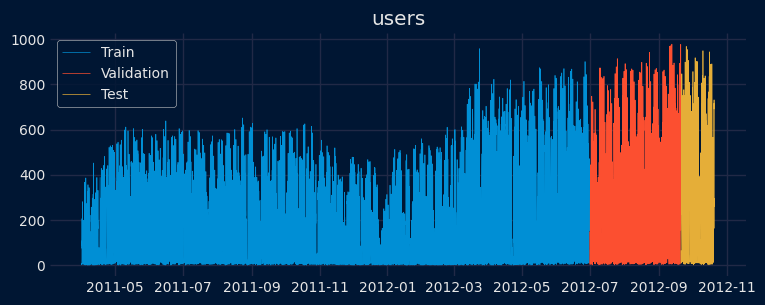

In [12]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['users'], label='Train')
ax.plot(data_val['users'], label='Validation')
ax.plot(data_test['users'], label='Test')
ax.set_title('users')
ax.legend();

## Predictions intervals


Prediction intervals are calculated for the test set using the bootstrapped residuals method with in-sample residuals.

In [ ]:
# Create and fit forecaster
# ==============================================================================
params = {
    "max_depth": 4,
    "n_estimators": 300,
    "learning_rate": 0.06,
}
lags = [1, 2, 3, 23, 24, 25, 167, 168, 169]
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags            = lags,
                 window_features = window_features,
             )

# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_calibration]),
         refit              = False
     )

metric, predictions_test = backtesting_forecaster(
                            forecaster              = forecaster,
                            y                       = data['users'],
                            cv                      = cv,
                            metric                  = 'mean_absolute_error',
                            interval                = [10, 90],  # 80% prediction interval
                            interval_method        = 'bootstrapping',
                            n_boot                  = 150,
                            use_in_sample_residuals = True,  # Use in-sample residuals
                            verbose                 = False,
                            show_progress           = True
                        )
predictions_test.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-09-21 00:00:00,86.857534,53.891584,117.147499
2012-09-21 01:00:00,46.493850,5.302836,94.652088
2012-09-21 02:00:00,23.044845,-11.240871,75.206585
2012-09-21 03:00:00,10.279069,-13.034499,62.527984
2012-09-21 04:00:00,12.284945,-8.793079,109.636013


Predicted interval coverage: 67.78 %
Area of the interval: 96753.32


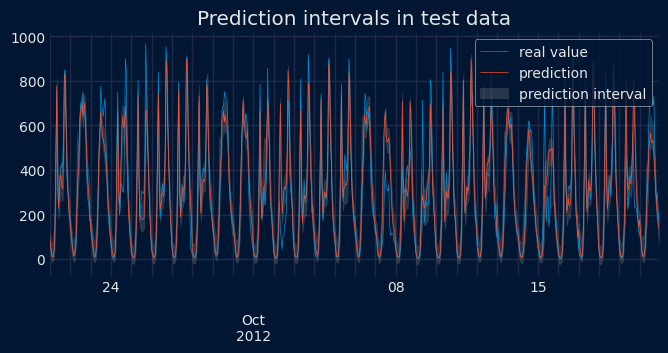

In [ ]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions_test,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true = data.loc[end_calibration:, 'users'],
    lower_bound = predictions_test["lower_bound"], 
    upper_bound = predictions_test["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_test["upper_bound"] - predictions_test["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

As expected, since in-sample residuals are used, the prediction intervals are too narrow and do not cover the actual values.

## Calibrate prediction intervals

Using the `ConformalInterval` transformer, we calibrate the prediction intervals generated by the bootstrapped residuals method. The `ConformalInterval` transformer uses the Split Conformal Prediction (SCP) method to learn the correction factor need to expand or shrink the prediction intervals to ensure they are valid with respect to the coverage probability.

In [15]:
# Predict intervals in calibration (validation data)
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_cal = backtesting_forecaster(
                        forecaster              = forecaster,
                        y                       = data['users'],
                        cv                      = cv,
                        metric                  = 'mean_absolute_error',
                        interval                = [10, 90],  # 80% prediction interval
                        interval_method        = 'bootstrapping',
                        n_boot                  = 150,
                        use_in_sample_residuals = True,  # Use in-sample residuals
                        verbose                 = False,
                        show_progress           = True
                     )

predictions_cal.head(5)

  0%|          | 0/112 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-07-01 00:00:00,119.148650,81.478601,154.877962
2012-07-01 01:00:00,109.449676,60.130117,142.220765
2012-07-01 02:00:00,82.840547,40.785705,128.980499
2012-07-01 03:00:00,44.658900,-3.847911,87.731376
2012-07-01 04:00:00,18.804497,-19.296629,67.367624


In [16]:
# Fit a ConformalInterval transformer
# ==============================================================================
conformal_interval = ConformalInterval()
conformal_interval.fit(
    y_true_calibrarion   = data.loc[predictions_cal.index, 'users'],
    calibration_interval = predictions_cal[['lower_bound', 'upper_bound']],
    nominal_coverage     = 0.8
)

In [19]:
predictions_test_calibrated = conformal_interval.transform(
                                predictions_test[["lower_bound", "upper_bound"]]
                              )

AttributeError: module 'numpy' has no attribute 'range'

In [ ]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_calibration:, 'users'],
    lower_bound = predictions_test_calibrated["lower_bound"], 
    upper_bound = predictions_test_calibrated["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_test_calibrated["upper_bound"] - predictions_test_calibrated["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The prediction intervals generated using conformal prediction achieve an empirical coverage very close to the nominal coverage of 80%.